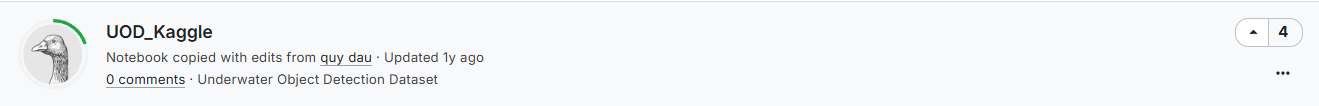

In [1]:
# Importing the required libraries
import os
import random
import pandas as pd
import wandb

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

c:\Users\Leaper\anaconda3\envs\yolov10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# # Wandb login:
# wandb.login(key="a96035366c44c4ac930354c4d3bda0f9499c339e")
# # Start a new wandb run to track this script.
# project_name = "yolov8_custom_training"
# run_name = "yolov8n_custom_run"
# hyperparameters = {
#     "epochs": 100,
#     "batch_size": 16,
#     "imgsz": 640,
#     "seed": 42,
#     "workers": 4
# }
# config = {
#     "project": project_name,
#     "name": run_name,
#     "notes": "Custom YOLOv8 training with Wandb",
#     "tags": ["yolov8", "custom"],
#     "job_type": "training",
#     "params": hyperparameters
# }
# wandb.init(config=config)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Leaper\_netrc
wandb: Currently logged in as: huchencao08 (huchencao08-shanghai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Define the paths to the images and labels directories
data_path = r"F:\dataSet\PE\QZYD\Raodu\dataSet_YOLO"
data_path = data_path.replace('\\', '/')

train_images = data_path + '/train/images'
train_labels =  data_path + '/train/labels'

val_images =  data_path + '/valid/images'
val_labels =  data_path + '/valid/labels'

test_images =  data_path + '/test/images'
test_labels =  data_path + '/test/labels'

# Define the path to the yaml data file
yaml_path =  data_path + '/data.yaml'

In [4]:
# Define the labels
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


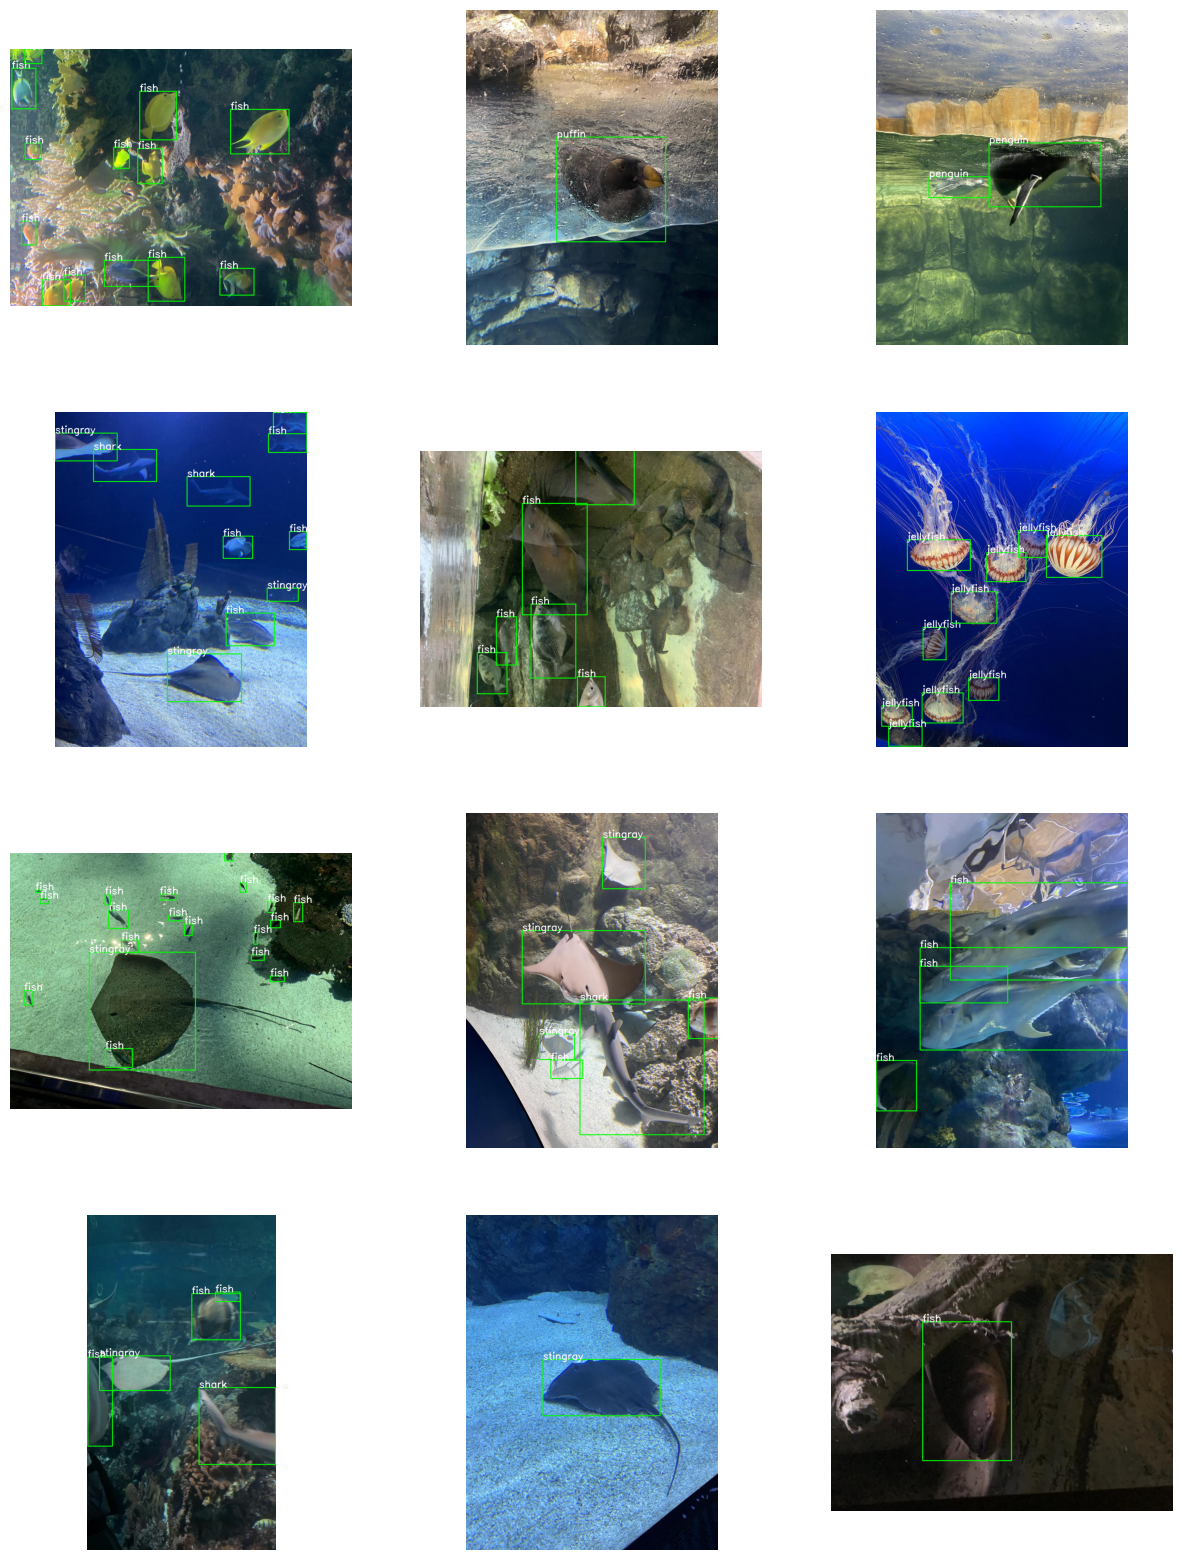

In [5]:
import os
import random
import pandas as pd
import wandb

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    
    image_files = sorted(os.listdir(image_dir))
    
    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)
    
    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    
    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3
        
        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')
        
        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [6]:
# Read a image by path
import os
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


In [7]:
%%writefile ./data.yaml
# Path
train: D:/code_study/ML_CODE/dataSets/ObjectDetection/Underwater_Object_Detection_Dataset/aquarium_pretrain/train/images
val: D:/code_study/ML_CODE/dataSets/ObjectDetection/Underwater_Object_Detection_Dataset/aquarium_pretrain/valid/images
test: D:/code_study/ML_CODE/dataSets/ObjectDetection/Underwater_Object_Detection_Dataset/aquarium_pretrain/test/images

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Overwriting ./data.yaml


In [1]:
from wandb.integration.ultralytics import add_wandb_callback
from ultralytics.models import YOLO
import torch
model = YOLO('yolov8n.pt')
add_wandb_callback(model,  enable_model_checkpointing=True)
# free up GPU memory
torch.cuda.empty_cache()

# Training the model
for epoch in range(hyperparameters["epochs"]):

    results = model.train(
        data='./data.yaml',
        #epochs=hyperparameters["epochs"],
        imgsz=hyperparameters["imgsz"],
        seed=hyperparameters["seed"],
        batch=hyperparameters["batch_size"],
        workers=hyperparameters["workers"],
        name=run_name,)
        # 提取日志中的指标（如 mAP）
    mAP = results.metrics["mAP"]
    wandb.log({"mAP": mAP, "epoch": epoch})
    

c:\Users\Leaper\anaconda3\envs\yolov10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


NameError: name 'hyperparameters' is not defined

In [2]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_custom/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

NameError: name 'pd' is not defined

In [3]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_custom/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

FileNotFoundError: [Errno 2] No such file or directory: '\\kaggle\\working\\runs\\detect\\yolov8n_custom\\weights\\best.pt'

In [4]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

NameError: name 'metrics' is not defined

In [5]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Pass the image through the detection model and get the result
    detect_result = model(image)
    
    # Plot the detections
    detect_image = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)
    
    return detect_image

In [6]:
# Get list of all the image files in the test directory
image_files = sorted(os.listdir(test_images))
    
# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)
    
# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    
# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3
        
    # Load the current image and run object detection
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)
    
    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()

NameError: name 'os' is not defined